ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **29Apr21**

# 15. Peclet Interface-Coupled 1D with Dirichlet Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Interfacial Coupling](#interfacialcoupling)
 + [Weak Form](#dbcweak)
<br><br>
1. [Problem Solution](#solution)
 + [Code an Interfacial Partition Kernel](#partitionkernel)
 + [Compile and Link Application](#compile)
 + [Input File](#dbcinput)
 + [Run Application](#dbcrun)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
 + [Compute Error](#linearerror)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
 + [Compute Error](#quaderror)
<br><br>    
1. [High Peclet Number](#highpe)
 + [Quadratic Lagrange FEM Results](#highperesults1)
    - [Compute Error](#highperesults1error)
 + [Quadratic Lagrange FEM Results](#highperesults2)
    - [Compute Error](#highperesults2error)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

+ Introduce interface-coupling (with and without discontinuity) in the context of a Peclet problem studied in the notebook series 12/13/14; all past notebooks must be thoroughly reviewed.
+ Present the Galerkin weak form of the Peclet 1D problem with two unknown variables as described below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
+ <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span> 
+ The reader is supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df1, df2, 
                  title='No Title', 
                  u1_legend='no u1 legend',
                  u2_legend='no u2 legend',
                  u1_flux_legend='no u1 flux legend',
                  u2_flux_legend='no u2 flux legend',
                  flux_decimal_digits=5):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')
    import numpy as np

    (fig, ax1) = plt.subplots(1, figsize=(15, 6))

    ax1.plot(df1['x'], df1['u1'],'r*-',label=u1_legend)
    ax1.plot(df2['x'], df2['u2'],'r*--',label=u2_legend)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU1_x' in df1.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df1['x'], np.round(df1['diffFluxU1_x'],flux_decimal_digits),'*-', color='yellow', label=u1_flux_legend)
        
        if 'diffFluxU2_x' in df2.columns:
            ax2.plot(df2['x'], np.round(df2['diffFluxU2_x'],flux_decimal_digits),'*--', color='yellow', label=u2_flux_legend)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm$^2$-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Problem Statement](#toc)<a id="problem"></a>

There exists two kinds of coupling of unknown variables (or fields), one kind is when the fields share the same domain $\Omega$ and are coupled tightly over the entire $\Omega$. This is the kind that will be studied here. The other kind is when the fields do not share the same domain $\Omega$ and the coupling takes place on a portion of the boundary of $\Omega$ shared by the fields. This latter case will be described in a future notebook.

The following sections describe an extension of the Peclet problem described in previous notebooks for the case when two fields are coupled through a source term.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Peclet model problem. Find $u_1:[a,b]\subset\Reals\rightarrow\Reals$ and $u_2:[b,c]\subset\Reals\rightarrow\Reals$ for $D_1 > 0$ and $D_2 > 0$ such that:

\begin{align*}
  v\, u_1' &= -\bigl(-D_1\, u_1'\bigr)'(x) + S(u_1, u_2) \quad \forall \quad x\in [a,b[, \\
 u_1(a) &= A_1,
\end{align*}

and

\begin{align*}
  v\, u_2' &= -\bigl(-D_2\, u_2'\bigr)'(x) - S(u_1, u_2) \quad \forall \quad x\in\, ]b,c], \\
 u_2(c) &= A_2.
\end{align*}

The *diffusion flux* associated to the quantity $u_i, \, \ i=1,2$ is denoted $q_i := -D_i\,u_i'$, and it is often of interest as a derived quantity. Here a point-wise *convective sink (or sweep)* is given by $v\,u_i'$. There exists two Peclet numbers: 

  + Peclet number: $\frac{v\,L}{D_i}$. 

whose effects has been described in earlier notebooks.

Likewise in the single-field Peclet 1-D problem (Notebook 09), the values of the dependent variables are given on the two end points of the domain (*essential* boundary conditions or  *Dirichlet boundary conditions*).

### [Interfacial Coupling](#toc)<a id="interfacialcoupling"></a>

Consider the following interfacial continuity requirement:

\begin{align*}
 u_1(b) &= u_2(b) \\
 q_{n,1}(b) &= q_{n,2}(b),
\end{align*}

that is, the fields and their **normal fluxes** are continuous at the interface $x = b$.

Consider the following interfacial conditions requirement:

\begin{align*}
 u_1(b) &= K\,u_2(b) \\
 q_{n,1}(b) &= q_{n,2}(b),
\end{align*}

that is, the fields are discontinuous at the interface and their **normal fluxes** are continuous at the interface $x = b$.

### [Weak Form of the Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin weak formulation with interfacial continuity condition is as follows. Find $u_1 \in H^1\!\bigl([a,b]\bigr)$ and $u_2 \in H^1\!\bigl([b,c]\bigr)$
so that 

\begin{align*}
 \int\limits_a^b v\, u_1'(x)\, w(x)\,dx + \int\limits_a^b D\, u_1'(x)\,w'(x)\,dx + \int\limits_a^b S_1\,w(x)\,dx &= 0 \quad \forall \quad w \in H^1_0\!\bigl([a,c]\bigr), \text{and}
 \\
  \int\limits_b^c v\, u_2'(x)\, w(x)\,dx + \int\limits_b^c D\, u_2'(x)\,w'(x)\,dx + \int\limits_b^c S_2\,w(x)\,dx &= 0 \quad \forall \quad w \in H^1_0\!\bigl([a,c]\bigr),
\end{align*}

where $H^1\!\bigl([x_i,x_j]\bigr) := \bigl\{ u:[x_i,x_j]\subset\Reals\rightarrow \Reals \mid \int_{x_i}^{x_j} u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,c]\bigr) := \bigl\{ w \mid w \in H^1(a,c), w(a) = 0, w(c) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$, $u_1$, $u_2$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

In view of the continuity of the fields and their normal fluxes at the interface, $x=b$ ([interfacial coupling](#interfacialcoupling)), the first modification needed in setting up a computational solution to the problem requires a geometric manipulation of the domain, that is, the domain $\Omega = [a,c]$ needs to be partitioned into sub-domains

\begin{align*}
\Omega &= \Omega_1 \cup \Omega_2, \quad \text{or here in 1-D:}\\
[a,c]  &= [a,b] \cup [b,c].
\end{align*}

This will be presented in the input file below.

The implementation of the finite element kernels in MOOSE does not allow for the continuous test function shown above. Therefore an independent weak form need to be implemented and the interface condition enforced in a weak sense. That is, the additional kernel resulting from the following weak statement on the interface:

\begin{align*}
 \bigl(u_1 - K\,u_2\bigr) \, w(b) = 0 \quad \forall \quad w \in L_2(b), \quad \text{for 2-D this reads:}
  \int_{I_{1,2}} \, \bigl(u_1 - K\,u_2\bigr) \, w \, da &= 0 \quad \forall \quad w \in L_2(I_{1,2}),
\end{align*}

needs to be created. The implementation is given in full below since a residual needs to be created for both finite elements sharing the interface.

Since the test function in MOOSE is built separately in each sub-domain, the continuity of the normal flux is obtained by providing the statement of the flux at the boundary between $\Omega_1$ and $\Omega_2$, that is $\{b\}$,

\begin{align*}
 q_{n_1,1}(b) \, w(b) = -q_{n_2,2}(b) \, w(b) =0  \quad \forall \quad w \in L_2(b), \quad \text{for 2-D this reads:} \int_{I_{1,2}} \, q_{n_1,1} \, w \, da = \int_{I_{1,2}} \,-q_{n_2,2} \, w \, da  \quad \forall \quad w \in L_2(I_{1,2}),
\end{align*}

for each sub-domain finite element at the interface. This is a matter involves details about meshing, therefore a full implementation is given below.

## [Problem Solution](#toc)<a id="solution"></a>

We will leverage the Peclet 1D, bulk coupling development (Notebook 11) to modify the domain of the problem and introduce the interface conditions.

### [Code an Interface Jump Condition Kernel](#toc)<a id="partitionkernel"></a>

An interfacial kernel is needed to enforce the jump condition. This is provided in the course template repository.

1. Starting from the project home directory.
1. `cd include`
1. `mkdir interfkernels`
1. `cd interfkernels`
1. Copy the [header file](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/InterfacePartition.h)
 + `cp *path-to*/moose-app-templates/InterfaceJump.h .`
 + Note the important members:
    ```c++
protected:
  virtual Real computeQpResidual(Moose::DGResidualType type) override;
  virtual Real computeQpJacobian(Moose::DGJacobianType type) override;
  /// Jump coefficient
  Real _kCoeff;
    ```
<br>
1. `cd ../..`
1. `cd src`
1. `mkdir interfkernels`
1. `cd interfkernels`
1. Copy the [implementation file](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/InterfacePartition.C)
 + `cp *path-to*/moose-app-templates/InterfaceJump.C .`
 + Edit the file `InterfaceJump.C` with a text editor addressing the `FIXME` instances.
 + Note the important members:
    - Residual:
```c++
Real
InterfaceJump::computeQpResidual(Moose::DGResidualType type)
{
  Real r = 0;
  switch (type)
  {
    // Primary residual = u_primary - k * u_neighbor
    // Weak form for primary domain is: (u_primary - k*u_neighbor, test)
    case Moose::Element:
      r = _test[_i][_qp] * (_u[_qp] - _kCoeff * _neighbor_value[_qp]);
      break;
    // Secondary residual: -(u_primary - k*u_neighbor, test),
    // flip the sign because the integration direction is opposite.
    case Moose::Neighbor:
      r = - _test_neighbor[_i][_qp] * (_u[_qp] - _kCoeff * _neighbor_value[_qp]);
      break;
  }
  return r;
}
```
    - Jacobian diagonal:
 ```c++
Real
InterfaceJump::computeQpJacobian(Moose::DGJacobianType type)
{
  Real jac = 0;
  switch (type)
  {
    case Moose::ElementElement:
      jac = _test[_i][_qp] * _phi[_j][_qp];
      break;
    case Moose::NeighborNeighbor:
      jac = -_test_neighbor[_i][_qp] * -_kCoeff * _phi_neighbor[_j][_qp];
      break;
    case Moose::NeighborElement:
      jac = -_test_neighbor[_i][_qp] * _phi[_j][_qp];
      break;
    case Moose::ElementNeighbor:
      jac = _test[_i][_qp] * -_kCoeff * _phi_neighbor[_j][_qp];
      break;
  }
  return jac;
}
 ```

### [Code an Interface Flux Condition](#toc)<a id="interffluxkernel"></a>

1. An interface normal (or any other direction) flux kernel is needed to enforce the flux condition required. While the normal flux is the only flux interfacial condition sought here, others can be implemented modifying the provided code below. Following similar steps as [above](#partitionkernel) create a kernel to enforce the continuity of the normal flux:

 + [Header file](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/InterfaceNormalFluxContinuity.h)
 + [Implementation file](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/InterfaceNormalFluxContinuity.C)


### [Compile and Link Application](#toc)<a id="compile"></a>

1. Make sure you are in the problem project:
 +  `cd ../..`
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="dbcinput"></a>

The domain partition and interface data set generation is as follows:

```
[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 25
  []
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 25
  []
# Stitch the domains
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'right left'
    clear_stitched_boundary_ids = 'true'
  []
# Label subdomains: Omega_1 and Omega_2
  [mod1]
    type = SubdomainBoundingBoxGenerator
    input = omega
    block_id = 1
    block_name = omega_1
    bottom_left = '${replace xmin} 0 0'
    top_right = '${replace x_interface} 1 0'
  []
  [mod2]
    type = SubdomainBoundingBoxGenerator
    input = mod1
    block_id = 2
    block_name = omega_2
    bottom_left = '${replace x_interface} 0 0'
    top_right = '${replace xmax} 1 0'
  []
# Create interface of subdomains: Omega_1 and Omega_2
  [mod3]
    type = SideSetsBetweenSubdomainsGenerator
    input = mod2
    primary_block = omega_1
    paired_block = omega_2 
    new_boundary = interface_12
  []
# Create the shared boundary of subdomains: Omega_1 and Omega_2
  [mod4]
    type = SideSetsAroundSubdomainGenerator
    input = mod3
    block = omega_1
    normal = '-1 0 0'
    new_boundary = omega_1_left
  []
  [mod5]
    type = SideSetsAroundSubdomainGenerator
    input = mod4
    block = omega_2
    normal = '1 0 0'
    new_boundary = omega_2_right
  []
[]
```
Enforcing the field partition at the interface:

```
[InterfaceKernels]
  [jump]
    type = InterfaceJump
    variable = u1
    neighbor_var = u2
    boundary = interface_12
    kCoeff = ${replace partition_coeff} # partition coefficient u1 = k * u2
  []
  [normal-flux-continuity]
    type = InterfaceNormalFluxContinuity
    variable = u1
    neighbor_var = u2
    boundary = interface_12
    diffCoeff = ${replace diff_coeff_1}
    diffCoeffNeighbor = ${replace diff_coeff_2}
  []
[]
```

### [Run Application](#toc)<a id="dbcrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + $a = 0$ cm
> + $b = 11$ cm
> + $c = 25$ cm

> + Pe$_\text{ave} = 5$
> + $K=1.2$

| $u_1$ **Parameter** | **Value**  | $u_2$ **Parameter** | **Value** |
|:-------------------:|:----------:|:-------------------:|:---------:|
| $A_1$               | 3 g/cc     |  $A_2$              | 0 g/cc    |
| $D_1$               | 0.1 cm^2/s |  $D_2$              | 0.3 cm^2/s  |
| $S_1$               | $1\times 10^{-3}$ g/cc-s |  $S_2$              | $-1\times 10^{-2}$ g/cc-s  |

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + Num. of finite elements: 25

In [2]:
'''Domain'''

x_a = 0
x_b = 25
x_interface = 11

x_length = x_b - x_a

In [3]:
'''Parameters and data'''

Pe_ave = 5 # mildly convective dominated

diff_coeff_1 = .1
source_s_1 = 3e-3

diff_coeff_2 = .3
source_s_2 = -1e-2

velocity = (Pe_ave * (diff_coeff_1+diff_coeff_2)/2/x_length, 0, 0)  # length scale is the x length

u1_a = 3
u2_c = 1

partition_coeff = 1.2

In [4]:
'''FEM Solution'''

n_felem_1 = 8
n_felem_2 = 10

order = 'first'

n_plot_pts_1 = n_felem_1 + 1
n_plot_pts_2 = n_felem_2 + 1

try:    
    from engy_5310.toolkit import write_engy5310_1d_interfacial_coupling_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_1d_interfacial_coupling_input_file(x_left=x_a, x_right=x_b, 
                                x_interface=x_interface,
                                u1_left=u1_a,
                                diff_coeff_1=diff_coeff_1, source_s_1=source_s_1,
                                u2_right=u2_c, 
                                diff_coeff_2=diff_coeff_2, source_s_2=source_s_2,
                                jump_coeff=partition_coeff,
                                velocity=velocity,
                                n_felem_1=n_felem_1, n_felem_2=n_felem_2,
                                order=order, 
                                n_plot_pts_1=n_plot_pts_1, n_plot_pts_2=n_plot_pts_2,
                                compute_diffusion_flux=True)
                                #solver='fdp-newt-full')

In [5]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 16May21 23:42:44

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
x_interface = 1.10000e+01

u1_left = 3.00000e+00
diff_coeff_1 = 1.00000e-01
source_s_1 = 3.00000e-03

u2_right = 1.00000e+00
diff_coeff_2 = 3.00000e-01
source_s_2 = -1.00000e-02

velocity = '4.00000e-02 0.00000e+00 0.00000e+00'
jump_coeff = 1.20000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace x_interface}
    nx = 8
  []
  [omega2]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace x_interface}
    xmax = ${replace xmax}
    nx = 10
  []
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'right left'
    clear_stitched_boundary_ids = 'true'
  []
# Create subdomains: Omega_1 and Omega_2
  [mod1]
    type = SubdomainBound

In [6]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


In ReplicatedMesh::stitch_meshes:
This mesh has 1 nodes on boundary 1.
Other mesh has 1 nodes on boundary 0.
Minimum edge length on both surfaces is 1.375.
In ReplicatedMesh::stitch_meshes:
Found 1 matching nodes.


Framework Information:
MOOSE Version:           git commit a7f499ed31 on 2021-04-30
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun May 16 23:42:45 2021
Executable Timestamp:    Sun May 16 22:56:20 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 19
    Local:                 19
  Elems:                   
    Total:                 18
    Local:                 18
  Num Subdomains:          2
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                20
  Num Loca

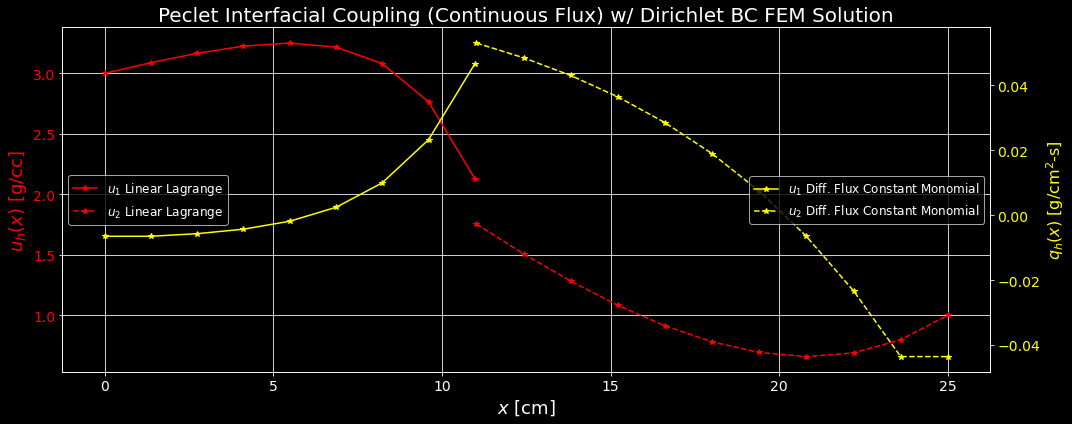

In [7]:
'''Show FEM Solution'''

import pandas as pd
df1 = pd.read_csv('output_omega_1_0002.csv')
df2 = pd.read_csv('output_omega_2_0002.csv')
    
plot_solution(df1, df2, title='Peclet Interfacial Coupling (Continuous Flux) w/ Dirichlet BC FEM Solution', 
              u1_legend=r'$u_1$ Linear Lagrange', u2_legend=r'$u_2$ Linear Lagrange',
              u1_flux_legend=r'$u_1$ Diff. Flux Constant Monomial',
              u2_flux_legend=r'$u_2$ Diff. Flux Constant Monomial')

**Comments:**

1. The jump in the fields at the interface leads to discontinous derivatives but the flux is enforced to be continuous. Note that the constant Lagrange basis functions used for computing the flux barely enforce the continuity accurately.

### [FEM Error](#toc)<a id="linearerror"></a>

In [8]:
'''Error Compared to Exact Dimensionless Solution'''

'''coming...'''

'coming...'

**Comments:**

1. TBA
1. TBA

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

Solve problem with the same parameter values as above.

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 20

In [9]:
'''FEM Solution'''

order = 'second'

n_plot_pts_1 = 2*n_felem_1 + 1
n_plot_pts_2 = 2*n_felem_2 + 1

try:    
    from engy_5310.toolkit import write_engy5310_1d_interfacial_coupling_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_1d_interfacial_coupling_input_file(x_left=x_a, x_right=x_b, 
                                x_interface=x_interface,
                                u1_left=u1_a,
                                diff_coeff_1=diff_coeff_1, source_s_1=source_s_1,
                                u2_right=u2_c, 
                                diff_coeff_2=diff_coeff_2, source_s_2=source_s_2,
                                jump_coeff=partition_coeff,
                                velocity=velocity,
                                n_felem_1=n_felem_1, n_felem_2=n_felem_2,
                                order=order, 
                                n_plot_pts_1=n_plot_pts_1,
                                n_plot_pts_2=n_plot_pts_2,
                                compute_diffusion_flux=True)
                                #solver='fdp-newt-full')

In [10]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 16May21 23:42:46

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
x_interface = 1.10000e+01

u1_left = 3.00000e+00
diff_coeff_1 = 1.00000e-01
source_s_1 = 3.00000e-03

u2_right = 1.00000e+00
diff_coeff_2 = 3.00000e-01
source_s_2 = -1.00000e-02

velocity = '4.00000e-02 0.00000e+00 0.00000e+00'
jump_coeff = 1.20000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace x_interface}
    nx = 8
    elem_type = edge3
  []
  [omega2]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace x_interface}
    xmax = ${replace xmax}
    nx = 10
    elem_type = edge3
  []
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'right left'
    clear_stitched_boundary_ids = 'true'
  []
# Create subdomains: Omega_1 an

In [11]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


In ReplicatedMesh::stitch_meshes:
This mesh has 1 nodes on boundary 1.
Other mesh has 1 nodes on boundary 0.
Minimum edge length on both surfaces is 1.375.
In ReplicatedMesh::stitch_meshes:
Found 1 matching nodes.


Framework Information:
MOOSE Version:           git commit a7f499ed31 on 2021-04-30
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun May 16 23:42:46 2021
Executable Timestamp:    Sun May 16 22:56:20 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 37
    Local:                 37
  Elems:                   
    Total:                 18
    Local:                 18
  Num Subdomains:          2
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                38
  Num Loca

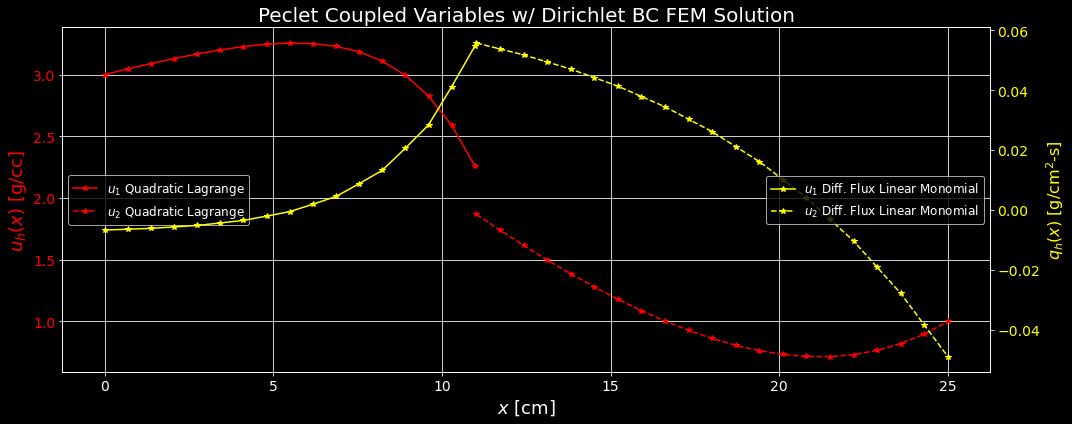

In [12]:
'''Show FEM Solution'''

import pandas as pd
df1 = pd.read_csv('output_omega_1_0002.csv')
df2 = pd.read_csv('output_omega_2_0002.csv')
    
plot_solution(df1, df2, title='Peclet Coupled Variables w/ Dirichlet BC FEM Solution', 
              u1_legend=r'$u_1$ Quadratic Lagrange', u2_legend=r'$u_2$ Quadratic Lagrange',
              u1_flux_legend=r'$u_1$ Diff. Flux Linear Monomial',
              u2_flux_legend=r'$u_2$ Diff. Flux Linear Monomial')

**Comments:**

1. The use of a higher order method with the same number of finite elements does a much better job at enforcing the continuity of the flux.
1. Capturing discontinuities at an interface accurately often requires higher order methods.

### [FEM Error](#toc)<a id="quaderror"></a>


In [13]:
'''Error Compared to Exact Dimensionless Solution'''

'''comming...'''

'comming...'

**Comments:**

1. TBA

## [High Peclet Number](#toc)<a id="highpe"></a>

Highly convective problems may lead to numerical difficulties. Below, enough finite elements are chosen so to avoid oscillations. 

### [Quadratic Lagrange FEM](#toc)<a id="highperesults1"></a>

Solve problem with the same parameter values above.

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + Num. of finite elements: 25

In [14]:
'''Parameters and data'''

Pe_ave = 50 # convective dominated

velocity = (Pe_ave * (diff_coeff_1+diff_coeff_2)/2/x_length, 0, 0)  # length scale is the x length

In [15]:
'''FEM Solution'''

n_felem_1 = 12
n_felem_2 = 15

order = 'second'

n_plot_pts_1 = 2*n_felem_1 + 1
n_plot_pts_2 = 2*n_felem_2 + 1

try:    
    from engy_5310.toolkit import write_engy5310_1d_interfacial_coupling_input_file  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

write_engy5310_1d_interfacial_coupling_input_file(x_left=x_a, x_right=x_b, 
                                x_interface=x_interface,
                                u1_left=u1_a,
                                diff_coeff_1=diff_coeff_1, source_s_1=source_s_1,
                                u2_right=u2_c, 
                                diff_coeff_2=diff_coeff_2, source_s_2=source_s_2,
                                jump_coeff=partition_coeff,
                                velocity=velocity,
                                n_felem_1=n_felem_1, n_felem_2=n_felem_2,
                                order=order, 
                                n_plot_pts_1=n_plot_pts_1,
                                n_plot_pts_2=n_plot_pts_2,
                                compute_diffusion_flux=True)
                                #solver='fdp-newt-full')

In [16]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem 1: Poisson 1D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 16May21 23:42:47

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
x_interface = 1.10000e+01

u1_left = 3.00000e+00
diff_coeff_1 = 1.00000e-01
source_s_1 = 3.00000e-03

u2_right = 1.00000e+00
diff_coeff_2 = 3.00000e-01
source_s_2 = -1.00000e-02

velocity = '4.00000e-01 0.00000e+00 0.00000e+00'
jump_coeff = 1.20000e+00

[Problem]
  type = FEProblem
  coord_type = XYZ
[]

[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace x_interface}
    nx = 12
    elem_type = edge3
  []
  [omega2]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace x_interface}
    xmax = ${replace xmax}
    nx = 15
    elem_type = edge3
  []
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'right left'
    clear_stitched_boundary_ids = 'true'
  []
# Create subdomains: Omega_1 a

In [17]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit


In ReplicatedMesh::stitch_meshes:
This mesh has 1 nodes on boundary 1.
Other mesh has 1 nodes on boundary 0.
Minimum edge length on both surfaces is 0.916667.
In ReplicatedMesh::stitch_meshes:
Found 1 matching nodes.


Framework Information:
MOOSE Version:           git commit a7f499ed31 on 2021-04-30
LibMesh Version:         27141d18f3137f77e33cdb3d565fd38ebfbfc46f
PETSc Version:           3.15.0
SLEPc Version:           3.14.2
Current Time:            Sun May 16 23:42:47 2021
Executable Timestamp:    Sun May 16 22:56:20 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   
    Total:                 55
    Local:                 55
  Elems:                   
    Total:                 27
    Local:                 27
  Num Subdomains:          2
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                56
  Num L

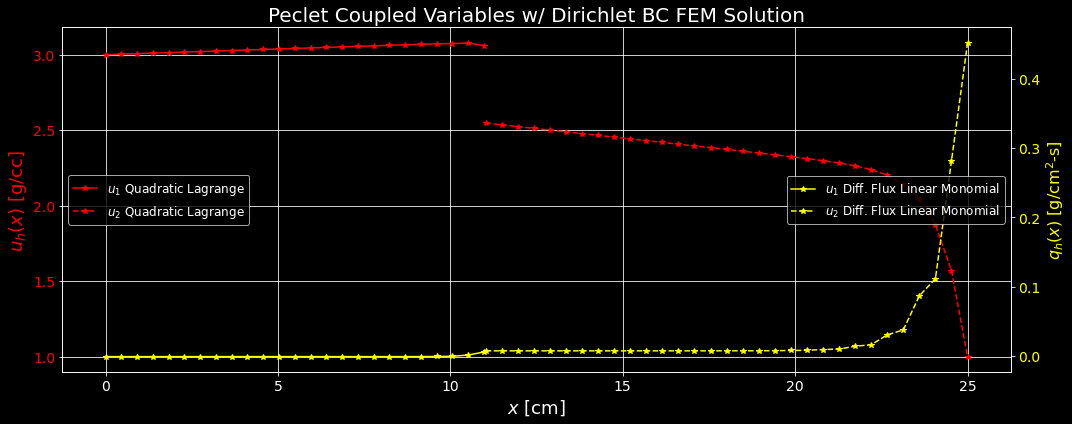

In [18]:
'''Show FEM Solution'''

import pandas as pd
df1 = pd.read_csv('output_omega_1_0002.csv')
df2 = pd.read_csv('output_omega_2_0002.csv')
    
plot_solution(df1, df2, title='Peclet Coupled Variables w/ Dirichlet BC FEM Solution', 
              u1_legend=r'$u_1$ Quadratic Lagrange', u2_legend=r'$u_2$ Quadratic Lagrange',
              u1_flux_legend=r'$u_1$ Diff. Flux Linear Monomial',
              u2_flux_legend=r'$u_2$ Diff. Flux Linear Monomial')

**Comments:**

This is a more challenging problem where convection dominates and leads to a boundary layer at the right side of the domain.

#### [Compute Error](#toc)<a id="highperesults1error"></a>


In [19]:
'''Flux Error Compared to Exact Dimensionless Solution'''

'''coming...'''

'coming...'

## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that covers various boundary conditions.

In [20]:
!tree engy5310p1

engy5310p1
├── LICENSE
├── Makefile
├── README.md
├── __pycache__
│   └── chigger.cpython-38.pyc
├── build
│   ├── header_symlinks
│   │   ├── BoundaryEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BoundaryEnergy.h
│   │   ├── BulkEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BulkEnergy.h
│   │   ├── ConvectionTerm.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/kernels/ConvectionTerm.h
│   │   ├── DiffusionFlux.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFlux.h
│   │   ├── DiffusionFluxComponent.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFluxComponent.h
│   │   ├── DiffusionTerm.h 